# setup

In [ ]:
! pip install -r requirements.txt

In [2]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Now you can access them
api_key = os.environ["AZURE_OPENAI_API_KEY"]
azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
api_version=os.environ["AZURE_OPENAI_API_VERSION"]
deployment=os.environ["AZURE_CHAT_DEPLOYMENT"]


# 1.Preprocess documents

In [3]:
from langchain.schema import Document
import json

def load_documents_from_json(json_path):
    """
    Load documents from the Document-format JSON
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Convert to LangChain Documents
    documents = []
    for doc_data in data['documents']:
        doc = Document(
            page_content=doc_data['page_content'],
            metadata=doc_data['metadata']
        )
        documents.append(doc)
    
    return documents

/home/lujain/anaconda3/envs/rag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
docs = load_documents_from_json('files/Labor_documents.json')

In [6]:
Arabic_docs = load_documents_from_json('files/Labor_A_documents.json')

In [5]:
docs[0]

Document(metadata={'part_number': 1, 'title': 'Definitions and General Provisions', 'pages': [2, 3, 4, 5, 6, 7], 'page_start': 2, 'page_end': 7, 'source': 'Labor', 'num_pages': 6}, page_content="## Part 1: Definitions and General Provisions\n### Chapter 1: Definitions\n#### Article 1\nThis law shall be called the Labor Law.\n#### Article 2\nIn this Law, the following terms shall have the meanings assigned thereto, unless the context requires otherwise:\n**Ministry:** Ministry of Labor.\n**Minister:** Minister of Labor.\n**Labor Office:** The administrative authority assuming jurisdiction over the labor affairs within an area specified by a decision of the Minister.\n**Employer:** Any natural or corporate person employing one or more workers for a wage.\n**Worker:** Any natural person - male or female - working for an employer and under his management or supervision for a wage, even if said person is not under his direct control.\n**Minor:** Any person of 15 and below 18 years of age.\n

In [7]:
Arabic_docs[0].metadata

{'part_number': 1,
 'title': 'الباب الأول',
 'pages': [3, 4, 5, 6, 7, 8],
 'page_start': 3,
 'page_end': 8,
 'source': 'arabic_law',
 'num_pages': 6}

# 2.Create a retriever tool

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3",model_kwargs = {'device': 'cuda:2'},encode_kwargs={"normalize_embeddings": True})

In [9]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

# 3- vector store
embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [10]:
vector_store.add_documents(documents=docs)
vector_store.add_documents(documents=Arabic_docs)

['de6a2129-b44b-488c-8115-ecf4338792bb',
 '1d75e423-87b7-40d1-af04-0851831ddee0',
 '423271d3-3ca4-43b9-be67-ce4fc0a20c05',
 '7ac22867-959c-48e4-b29d-5c3e82afd88a',
 '989cb228-487d-4ff3-8901-01fc325950f7',
 '56eb99cb-d632-4bc1-ab70-f0184856ecce',
 '718825b9-23fd-4484-a89f-21b2d27f9763',
 'bd948828-06f4-42b5-b213-3ab073e56b50',
 'b063af5d-757b-465e-9e9e-181775ce286f',
 'e8604a52-d8a2-43a1-886f-4751988f051c',
 '887ab33a-08e6-4495-a94c-d627f4b49eaf',
 'aac51679-4d0e-408c-896f-c2144df4566a',
 '7b08ad40-0915-4ddc-9ad4-b3d88789c87a',
 'ad533b92-ba96-413f-8811-efd862807ebf',
 '6e79baa0-4c9e-4b1a-b41e-2e117a5465ff',
 '2facfbd6-d3a3-4305-a539-4b2e06b88efc']

In [11]:
retriever = vector_store.as_retriever()

In [12]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "labor_law_retriever",
    "Search and return information about Saudi Labor Law. Use this tool to find information about all labor-related regulations in Saudi Arabia.",
)

below are 2 methods to call the retriver 

In [13]:
results = vector_store.similarity_search_with_score(
    "توظيف النساء", k=4, filter={"source": "arabic_law"}
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=0.936620] 09
الباب التاسع
تشغيل النساء
## المادة التاسعة والأربعون بعد المائة: 53 (ملغاة)
## المادة الخمسون بعد المائة: 54 (ملغاة)
## المادة الحادية والخمسون بعد المائة: 55
1. للمرأة العاملة الحق في إجازة وضع بأجر كامل لمدة (اثني عشر) أسبوعًا، منها وجوييًا الأسابيع الستة التالية للوضع، ولها أن توزع الأسابيع الستة المتبقية وفق ما تراه، ابتداءً من أربعة أسابيع قبل التاريخ المرجح للوضع. ويحدد التاريخ المرجح للوضع بموجب شهادة طبية مصدقة من جهة صحيحة. وفي حال قل المتبقي من مدة الإجازة عن (ستة) أسابيع نتيجة تأخر الوضع عن تاريخه المرجح، فتحتسب المدة المكملة لها إجازة دون أجر. وفي جميع الأحوال يحق للمرأة العاملة تمديد هذه الإجازة (شهراً) دون أجر.
2. للمرأة العاملة - في حالة إنجاب طفل مريض أو من ذوي الإعاقة وتتطلب حالته الصحية مرافقاً مستمراً له- الحق في إجازة مدتها (شهر) بأجر كامل تبدأ بعد انتهاء مدة إجازة الوضع، ولها الحق في تمديد الإجازة لمدة شهر دون أجر.
## المادة الثانية والخمسون بعد المائة: 56 (ملغاة)
### المادة الثالثة والخمسون بعد المائة:
على صاحب العمل توفير الرعاية الطبية للمرأ

In [14]:
retriever_tool.invoke({"query": "recurting women"})

'## PART 9: Employment of Women\n### Article 149\nRepealed\n### Article 150\nRepealed\n### Article 151\n1. Female workers shall be entitled to fully paid maternity leave for a period of 10 weeks to be divided at the female worker\'s discretion. Such period may start four weeks prior to the expected date of delivery. Expected date of delivery shall be determined pursuant to a medical report certified by a health authority.\n2. A woman may not, under any circumstances, work during the six weeks immediately following delivery. She shall be entitled to extend the leave for an additional two months as unpaid leave.\n3. In the event of giving birth to a sick child or a child with special needs whose health condition requires a constant companion, a female worker shall be entitled to a one-month leave with full pay starting at the end of the maternity leave and she shall be entitled to extend the leave for an additional month as unpaid leave.\n### Article 152\nRepealed\n### Article 153\nAn em

# 3.Generate query

In [15]:
from langgraph.graph import MessagesState
from langchain_openai import AzureChatOpenAI

response_model = AzureChatOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    api_version=api_version,
    deployment_name=deployment,
    temperature=0.1
)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [16]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello there! 👋 How are you doing today?


In [17]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "what is the regulation for working women?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Let’s look up the relevant regulations for **working women** under the **Saudi Labor Law**.
Tool Calls:
  labor_law_retriever (call_yKwtGVmwiIpti85UkA2k3XMt)
 Call ID: call_yKwtGVmwiIpti85UkA2k3XMt
  Args:
    query: working women regulations


# 4.Grade documents

In [18]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = AzureChatOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    api_version=api_version,
    deployment_name=deployment,
    temperature=0.1
)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments, method="function_calling").invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

experiment:

In [19]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "what is the regulation for working women?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "labor_law_retriever",
                        "args": {"query": "working women regulations"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [20]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "what is the regulation for Employment of Women?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "labor_law_retriever",
                        "args": {"query": "Employment of Women regulations"},
                    }
                ],
            },
            {"role": "tool", "content": """## PART 9: Employment of Women\n### Article 149\nRepealed\n### Article 150\nRepealed\n### Article 151\n1. Female workers shall be entitled to fully paid maternity leave for a period of 10 weeks to be divided at the female worker\'s discretion. Such period may start four weeks prior to the expected date of delivery. Expected date of delivery shall be determined pursuant to a medical report certified by a health authority.\n2. A woman may not, under any circumstances, work during the six weeks immediately following delivery. She shall be entitled to extend the leave for an additional two months as unpaid leave.\n3. In the event of giving birth to a sick child or a child with special needs whose health condition requires a constant companion, a female worker shall be entitled to a one-month leave with full pay starting at the end of the maternity leave and she shall be entitled to extend the leave for an additional month as unpaid leave.\n### Article 152\nRepealed\n### Article 153\nAn employer shall provide medical care for female workers during pregnancy and delivery.\n### Article 154\nWhen a female worker returns to work following a maternity leave, she shall be entitled, in addition to the rest periods granted to all workers, to a rest period or periods not exceeding in aggregate one hour a day for nursing her infant. Such period or periods shall be calculated as part of the actual working hours and shall not entail any reduction in wage.\n### Article 155\nAn employer may not terminate the employment of a female worker or give her a warning of the same during her pregnancy or while she is on maternity leave. This shall include the period she is ill as a result of either of them, provided that her illness is documented pursuant to an official medical report, and that her absence does not exceed 180 days a year whether separately or consecutively.\n### Article 156\nRepealed\n### Article 157\nA female worker shall forfeit her entitlements under the provisions of this Part if she works for another employer during her authorized leave. In this case, the original employer may deprive her of her wage for the duration of the leave or recover any payments made to her.\n### Article 158\nIn all occupations and places where women are employed, the employer shall provide them with seats for resting.\n### Article 159\n1. An employer who employs 50 female workers or more shall provide them with a suitable place with an adequate number of babysitters to look after the female workers\' children under the age of six years, if the number of children reaches 10 or more.\n2. The Minister may require an employer who employs 100 women or more in a single city to set up a nursery, either on his own or in conjunction with other employers in the same city, or alternatively, to contract with an existing nursery to care for the children of the female workers who are under six years of age during work periods. In such case, the Minister shall set forth the terms and conditions regulating such facilities as well as the charges imposed on the female\nworkers benefiting from this service.\n### Article 160\n1. A Muslim female worker whose husband dies shall be entitled to \'iddah leave\' with full pay for a period of not less than four months and 10 days starting from date of death. If she is pregnant, such leave may be extended without pay until her delivery. She may not, following childbirth, use the remainder of the leave granted to her under this Law.\n2. A non-Muslim female worker whose husband dies shall be entitled to a fifteen-day leave with full pay.\nIn all cases, a female worker whose husband dies may not work for others during the leave period.\nThe employer shall have the right to request supporting documents in the abovementioned cases.\n\n# PART 12: Working in Mines and Quarries\n## Article 185\nWorking in mines and quarries shall mean the following:\n1. Operations involving prospecting, detecting, extracting, or manufacturing (solid or liquid) mineral substances, including precious stones, in the area for which the license was issued.\n2. Operations involving extracting, concentrating, or manufacturing mineral sediments on the surface or under the\nground in the area of the license.\n3. Construction works and the installation of structures and equipment related to the operations referred to in paragraphs (1) and (2) of this Article.\n### Article 186\nNo person under the age of 18 may be employed in a mine or quarry.\n### Article 187\nNo person shall be allowed to engage in operations subject to the provisions of this Part until he undergoes a complete medical examination and is proven to be physically fit for the required work. Such examination shall be repeated periodically. The worker may not be required to bear the costs of necessary medical examinations. The Minister shall set forth, pursuant to a decision by him, the terms, conditions, and periods that must be complied with.\n### Article 188\nThe actual working hours spent by the worker underground shall not exceed seven hours a day. No worker shall be kept at the workplace, above or below the ground, for more than 10 hours a day. If the work is conducted underground, such a period shall include the time needed for the worker to reach underground and the time needed to return to the surface.\n### Article 189\nAccess to the work location and facilities shall be restricted to workers therein, persons authorized to inspect the mine or quarry, and persons holding special permits from the competent authority.\n### Article 190\nAn employer shall keep a record to register and count the workers before they enter the workplace and as they exit therefrom.\n### Article 191\nAn employer or the manager in-charge shall draft a list of orders and instructions related to public safety.\n### Article 192\nAn employer shall establish a rescue point in the vicinity of the workplace, equipped with necessary rescue and first aid equipment. Said point shall be equipped with suitable means of communication for immediate access, and the employer shall appoint a trained technician to supervise rescue and first aid operations.\n### Article 193\nWithout prejudice to the provisions of Article 142 of this Law, the employer of each mine or quarry with at least 50 workers\nshall set up a suitable location with a room equipped with rescue and first aid equipment, another room for nursing, and one or more locker rooms. As for quarries and mines with less than 50 workers and which are located within a twenty-kilometer radius of each other, employers may pool their resources to establish a place of rescue and first aid in between such quarries and mines, or else establish their own places of rescue and first aid.\nThe Minister may determine the rescue and first aid equipment and the protection and prevention measures in mines and quarries as well as employers\' responsibilities and workers\' rights and duties."""
             , "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'generate_answer'

# 5.Rewrite question

In [21]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [22]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

An improved version of the question could be:

**"According to Lilian Weng, what are the main types or categories of reward hacking in reinforcement learning, and how do they manifest in AI systems?"**


# 6.Generate an answer

In [23]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks about saudi labor law. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. \n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [24]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng explains that reward hacking can be categorized into two types: **environment or goal misspecification** and **reward tampering**.


# 7.Assemble the graph

In [25]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

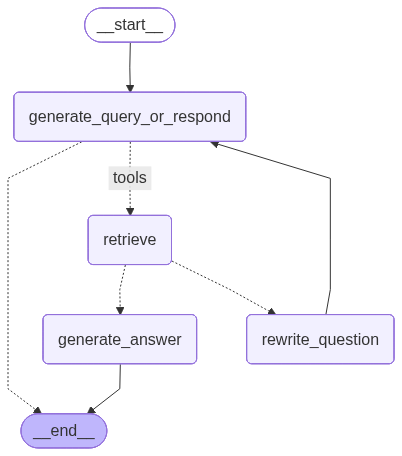

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is the regulation for Employment of women?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

Let's look up the regulation for **Employment of Women** under the Saudi Labor Law.
Tool Calls:
  labor_law_retriever (call_aunH3sDegCu7zydDuIkE86pv)
 Call ID: call_aunH3sDegCu7zydDuIkE86pv
  Args:
    query: Employment of women



Update from node retrieve
================================= Tool Message =================================
Name: labor_law_retriever

## PART 9: Employment of Women
### Article 149
Repealed
### Article 150
Repealed
### Article 151
1. Female workers shall be entitled to fully paid maternity leave for a period of 10 weeks to be divided at the female worker's discretion. Such period may start four weeks prior to the expected date of delivery. Expected date of delivery shall be determined pursuant to a medical report certified by a health authority.
2. A woman may not, under any circumstances, work during the six weeks immediately followin